# Tagup Data Science Exercise

ExampleCo, Inc is gathering several types of data for its fleet of very expensive machines.  These very expensive machines have three operating modes: *normal*, *faulty* and *failed*.   The machines run all the time, and usually they are in normal mode.  However, in the event that the machine enters faulty mode, the company would like to be aware of this as soon as possible.  This way they can take preventative action to avoid entering failed mode and hopefully save themselves lots of money.

They collect four kinds of timeseries data for each machine in their fleet of very expensive machines.  When a machine is operating in *normal* mode the data behaves in a fairly predictable way, but with a moderate amount of noise.  Before a machine fails it will ramp into *faulty* mode, during which the data appears visibly quite different.  Finally, when a machine fails it enters a third, and distinctly different, *failed* mode where all signals are very close to 0.

You can download the data here: [exampleco_data](https://drive.google.com/open?id=1b12u6rzkG1AxB6wLGl7IBVoaoSoZLHNR)

__Your main objective: to develop an automated method to pinpoint the times of fault and failure in this machine__.  Keep in mind that you will be sharing these results with the executives at ExampleCo, so to the best of your ability, try to explain what you are doing, what you've shown, and why you think your predictions are good.


A few notes to help:
1. A good place to start is by addressing the noise due to communication
   errors.
2. Feel free to use any libraries you like, or even other programming
   languages. Your final results should be presented in this notebook, however.
3. There are no constraints on the techniques you bring to bear, we are curious
   to see how you think and what sort of resources you have in your toolbox.
4. Be sure to clearly articulate what you did, why you did it, and how the
   results should be interpreted. In particular you should be aware of the
   limitations of whatever approach or approaches you take.
5. Don't feel compelled to use all the data if you're not sure how. Feel free
   to focus on data from a single unit if that makes it easier to get started.
6. Don't hesitate to reach out to datasciencejobs@tagup.io with any questions!

In [1]:
# To help you get started...
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import math
from scipy import interpolate
from changepoint.variance_shift_model import VarianceShiftModel
import os
from scipy import interpolate
%matplotlib inline 

In [2]:
data = pd.read_csv('./data/exampleco_data/machine_1.csv')

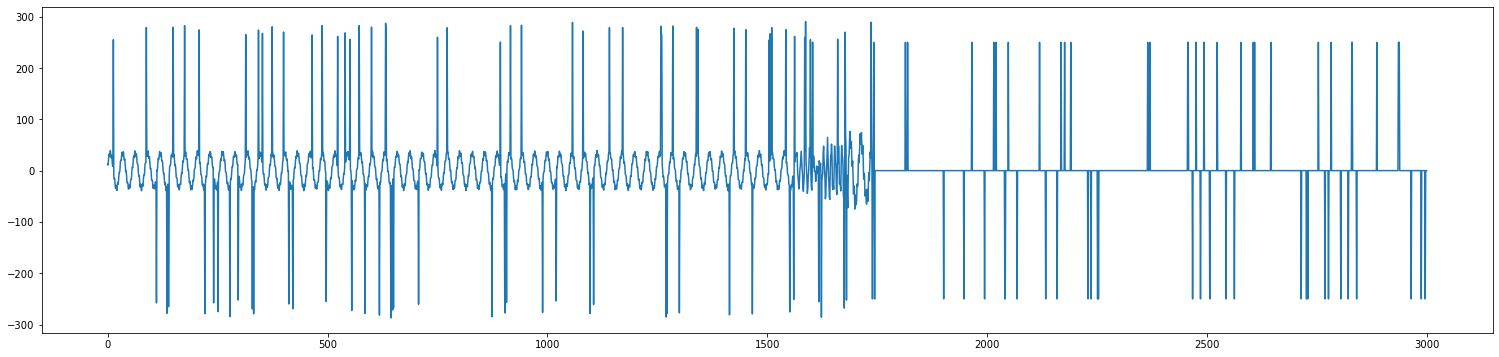

In [3]:
plt.figure(figsize=(26,6))
plt.plot(range(len(data)), data.iloc[:,1])

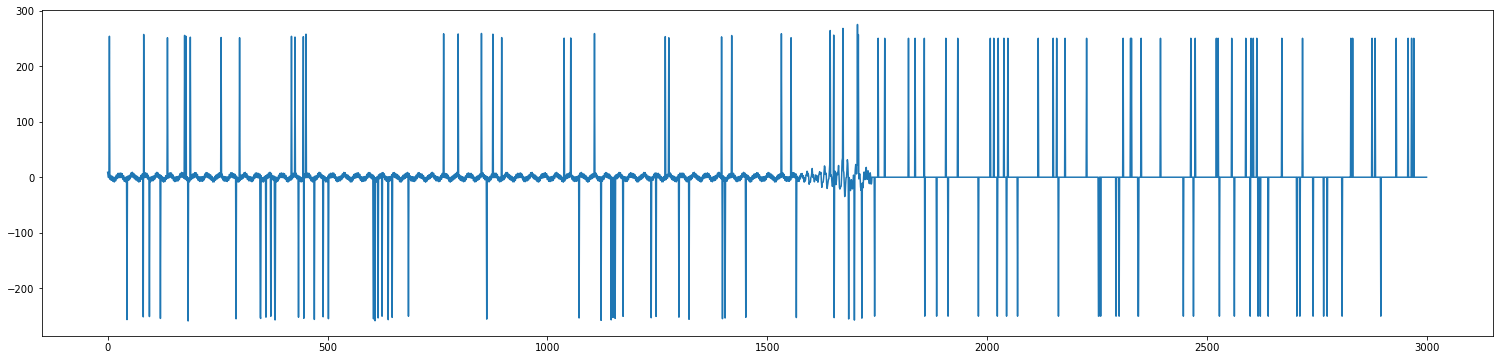

In [4]:
plt.figure(figsize=(26,6))
plt.plot(range(len(data)), data.iloc[:,2])

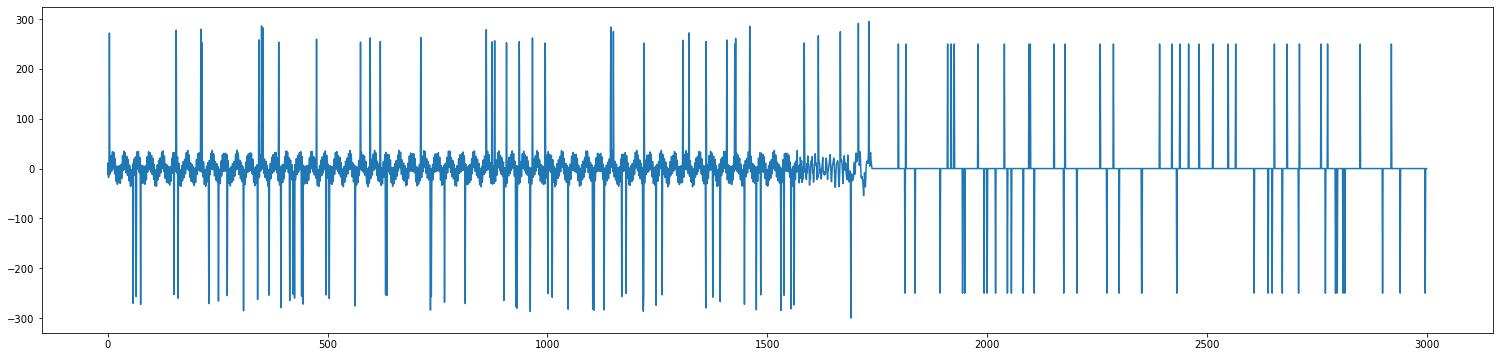

In [5]:
plt.figure(figsize=(26,6))
plt.plot(range(len(data)), data.iloc[:,3])

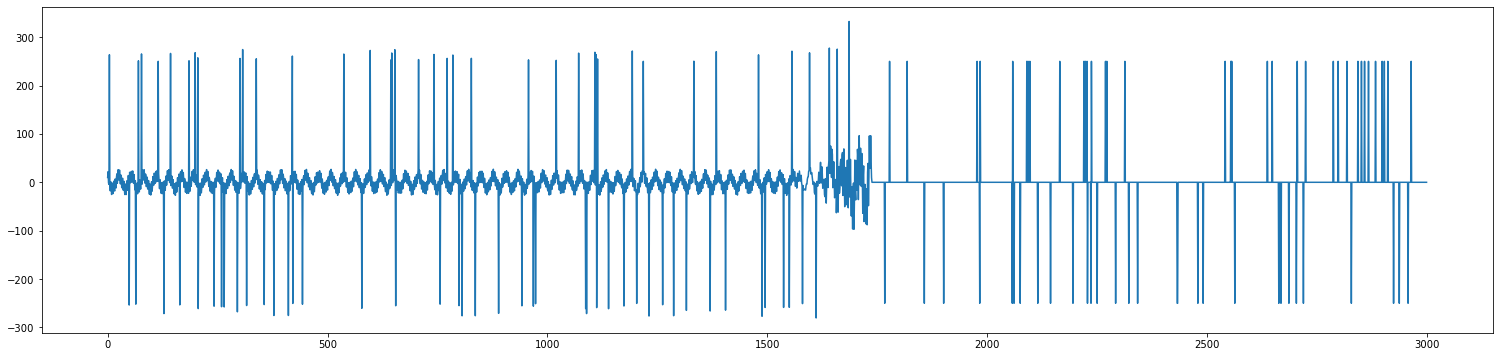

In [6]:
plt.figure(figsize=(26,6))
plt.plot(range(len(data)), data.iloc[:,4])

From the signals plotted above, we see that there is a change in variance when it changes from faulty to failure. We are essentially trying to capture that mode, since this is what is important to the business.

### Solution:
Here, we go over the solution for one of the machines. The basic idea is to first clean the signal and then detect a variance shift for each signal. Now, we take a look at each of the signal individually and report the earliest time where there was a variance shift.

### Helper Functions

In [7]:
def med_values_without_outliers(signal, threshold):
    '''
    Use median values to fill the outliers.
    '''
    sig_no_out = signal.apply(lambda x: x if (abs(x) < threshold) else None)
    sig_no_out = [x for x in sig_no_out if x]
    med_val =  np.nanmedian(sig_no_out)
    # Filling the outliers with median values
    sig_no_out = signal.apply(lambda x: x if (pd.isna(x)==False) and (abs(x) < threshold) else med_val)
    return sig_no_out

In [8]:
def fill_nan(A, threshold):
    '''
    interpolate to fill nan values
    '''
    A = A.apply(lambda x: x if (abs(x) < threshold) else None)
    A = A.values
    inds = np.arange(A.shape[0])
    good = np.where(np.isfinite(A))
    f = interpolate.interp1d(inds[good], A[good],kind="nearest", bounds_error=False)
    B = np.where(np.isfinite(A),A,f(inds))
    return B

### Part 1: Remove the data points due to communication errors.
I currently have two approaches to remove the data points. One is to interpolate using median values and the other is to interpolate with nearest values.


### Plots after filling with median value
1. we consider the threshold value to be 100. Datapoints that have an absolute value greater than 100 are considered to be outliers.

0    None
1    None
2    None
3    None
dtype: object

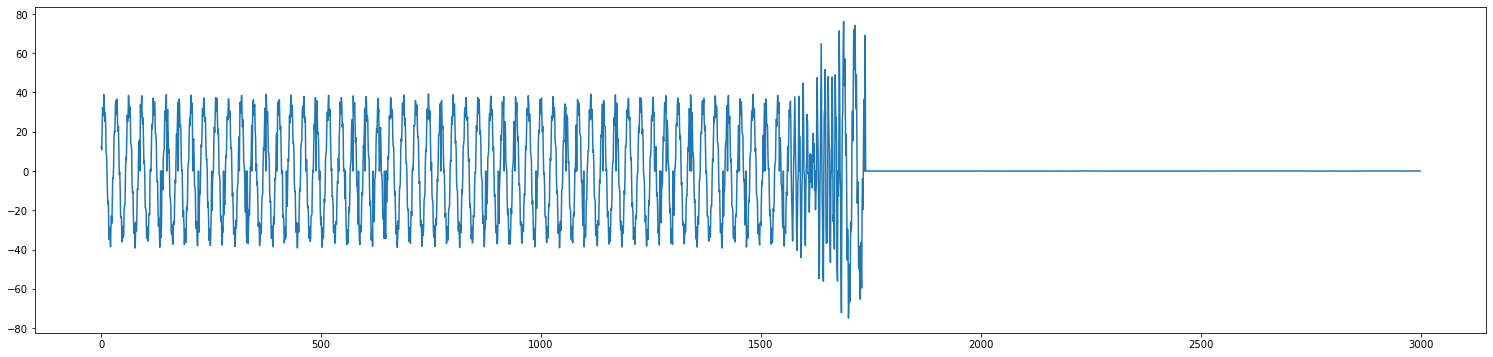

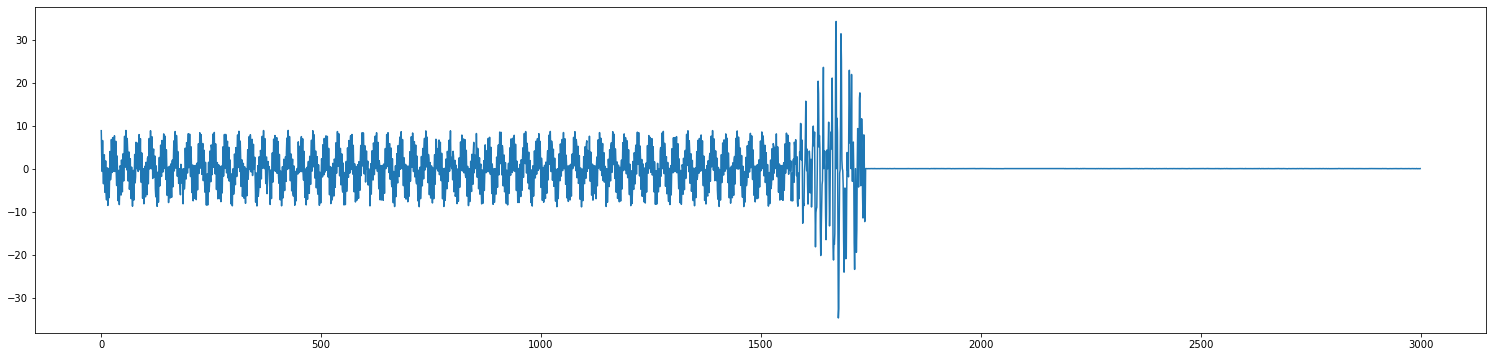

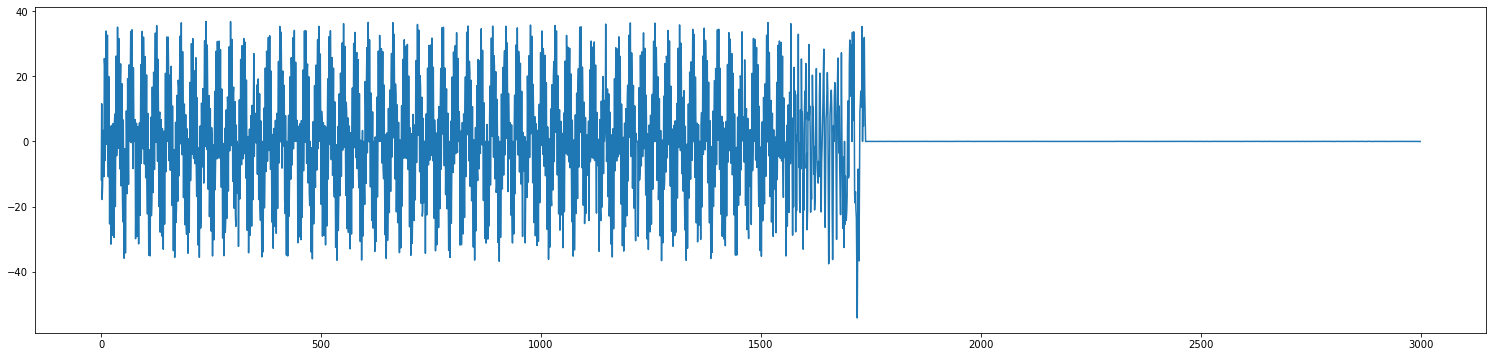

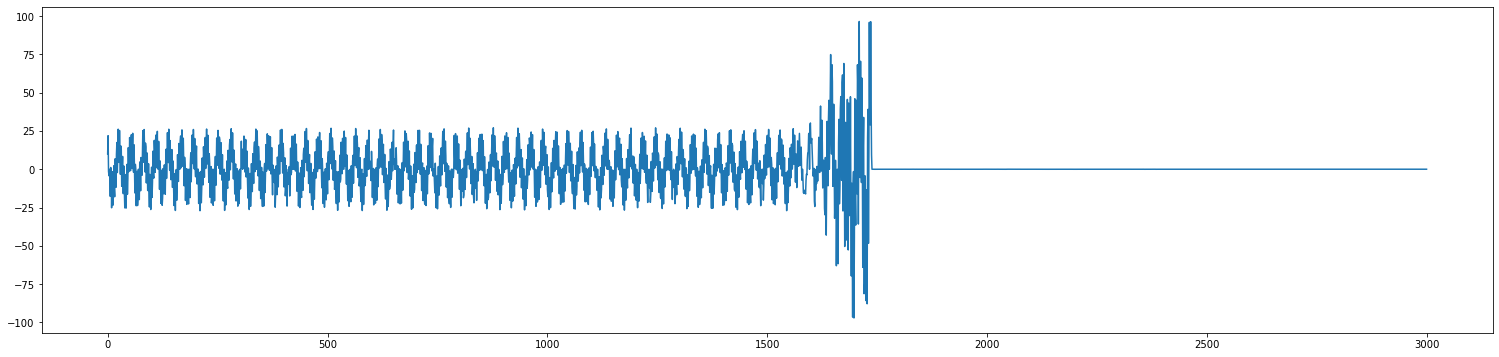

In [9]:
THRESHOLD = 100
def plot_median(signal):
    filtered_sig = med_values_without_outliers(signal, THRESHOLD)
    plt.figure(figsize=(26,6))
    plt.plot(range(len(signal)), filtered_sig)

data.iloc[:, 1:].reset_index(drop=True).apply(lambda x: plot_median(x))

### Inference
We see that the rest of the noise is cleaned. Except for signal 3, we see that the rest of the signals have a clear variance shift in their signal.There will be a 

### Plots after interpolating with nearest values
1. we consider the threshold value to be 100. Datapoints that have an absolute value greater than 100 are considered to be outliers.

0    None
1    None
2    None
3    None
dtype: object

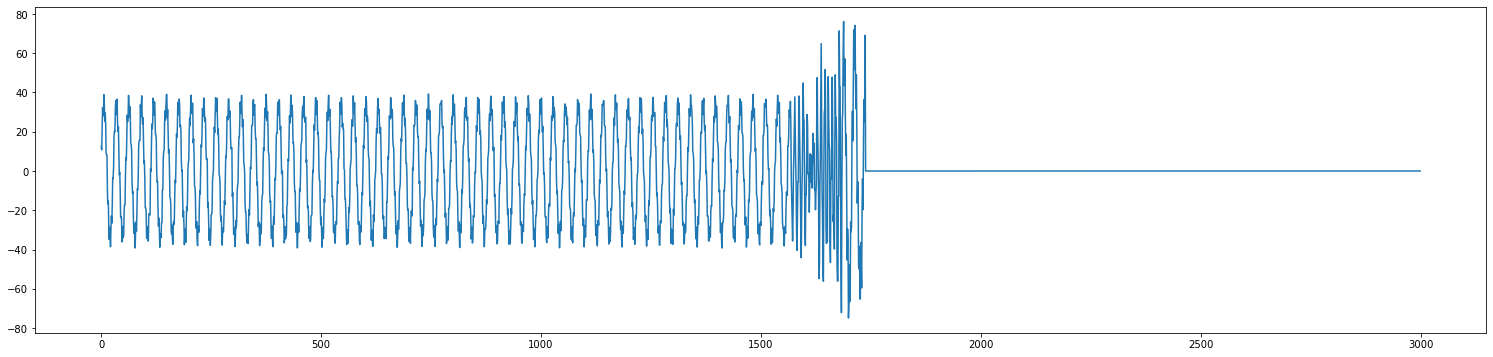

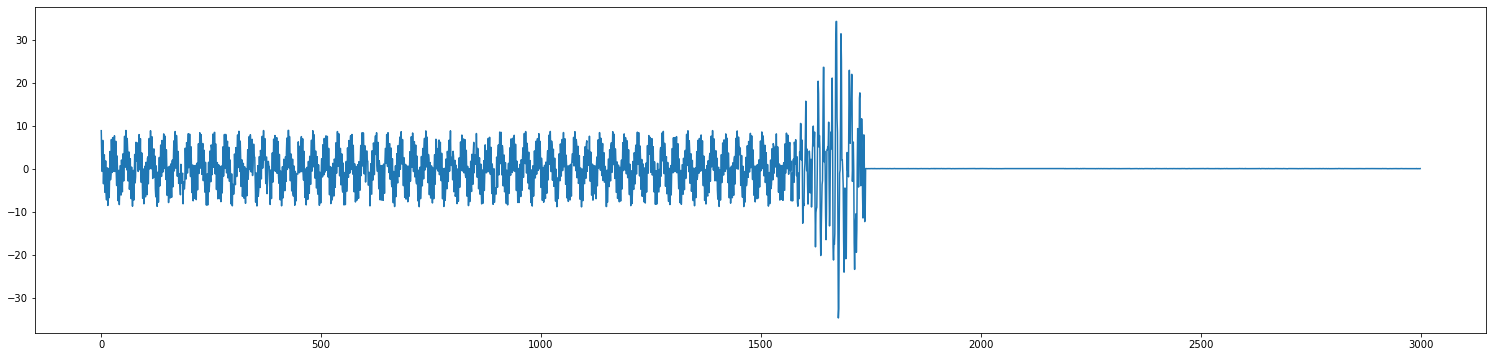

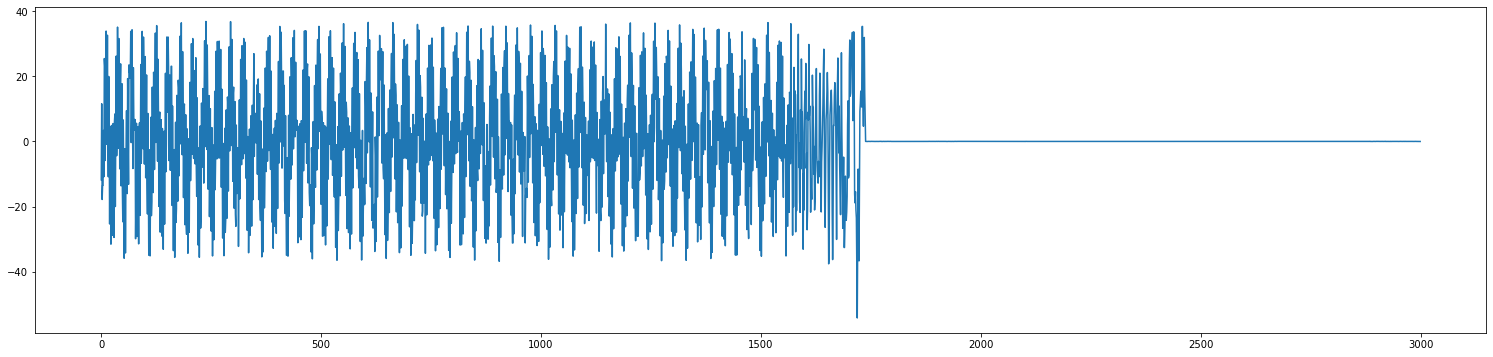

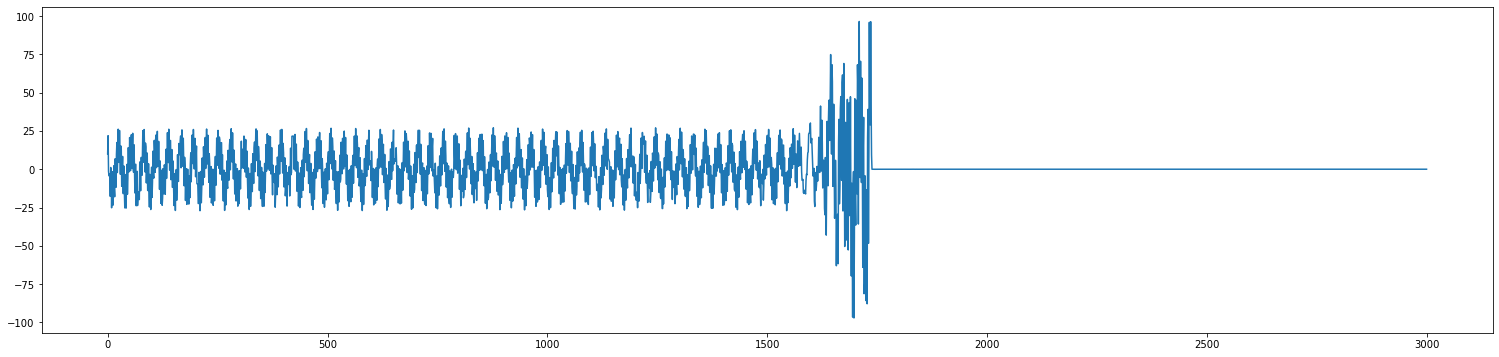

In [10]:
THRESHOLD = 100
def plot_interpolated(signal):
    filtered_sig = fill_nan(signal, THRESHOLD)
    plt.figure(figsize=(26,6))
    plt.plot(range(len(signal)), filtered_sig)

data.iloc[:, 1:].reset_index(drop=True).apply(lambda x: plot_interpolated(x))

### Inference:

1. Both methods produce similar outputs. Hence, we proceed on to use interpolation..

In [11]:
'''
filename = './model/changepoint_model.pkl'

if 'changepoint_model.pkl' not in os.listdir('./model/'):
    
else:
    infile = open(filename,'rb')
    model = pickle.load(infile)
    infile.close()
'''
    
model = VarianceShiftModel(50,1,5)

In [12]:
signal_cleaned = data.iloc[:, 1:].reset_index(drop=True).apply(lambda x: med_values_without_outliers(x, 100))

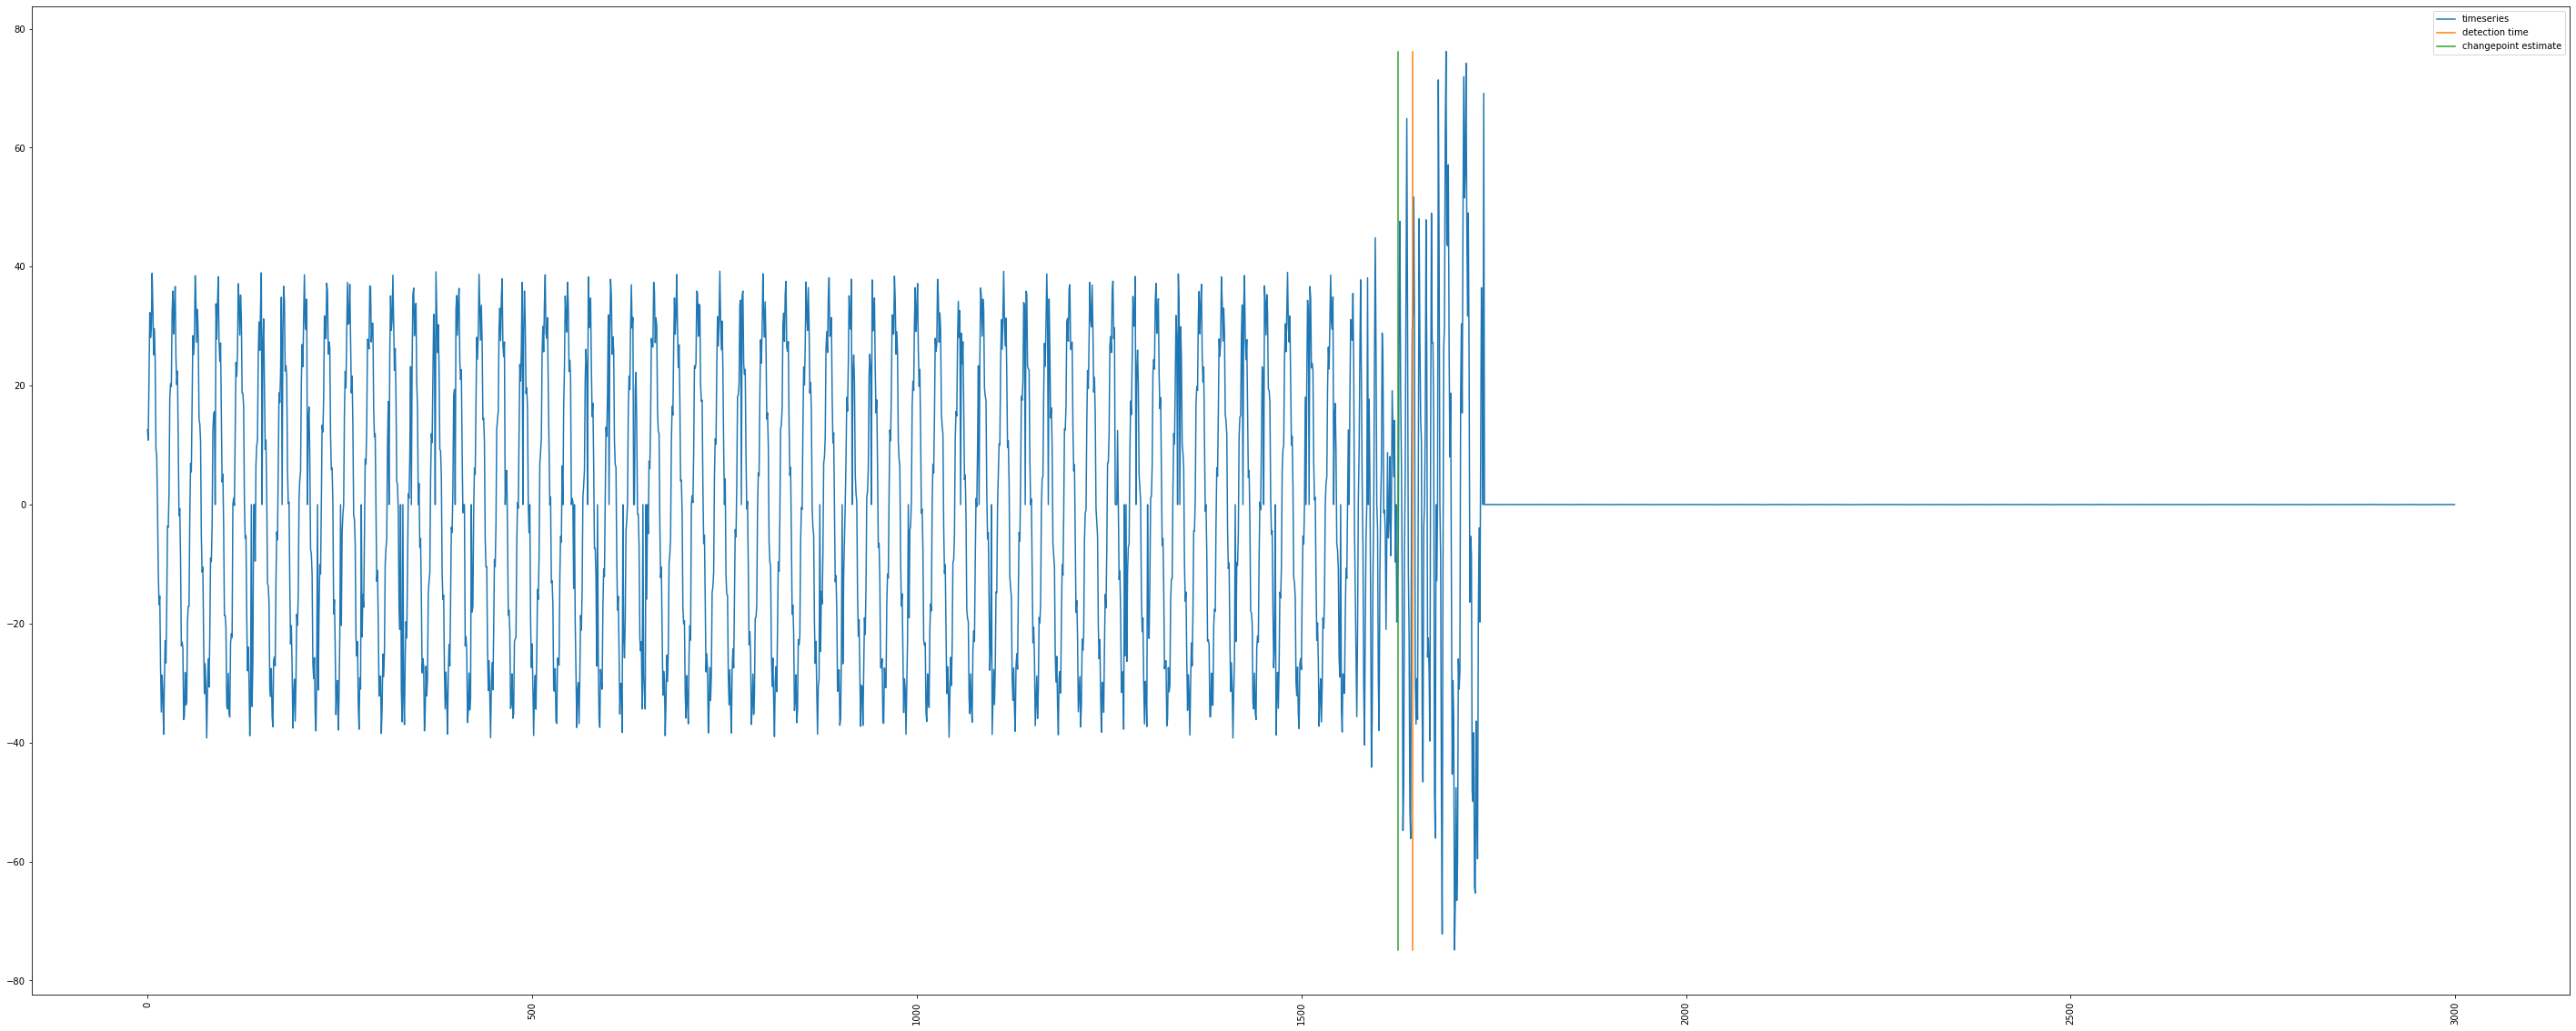

In [13]:
signal1_result = model.offlineDetection(signal_cleaned.iloc[:, 0].values, omit_na=False)

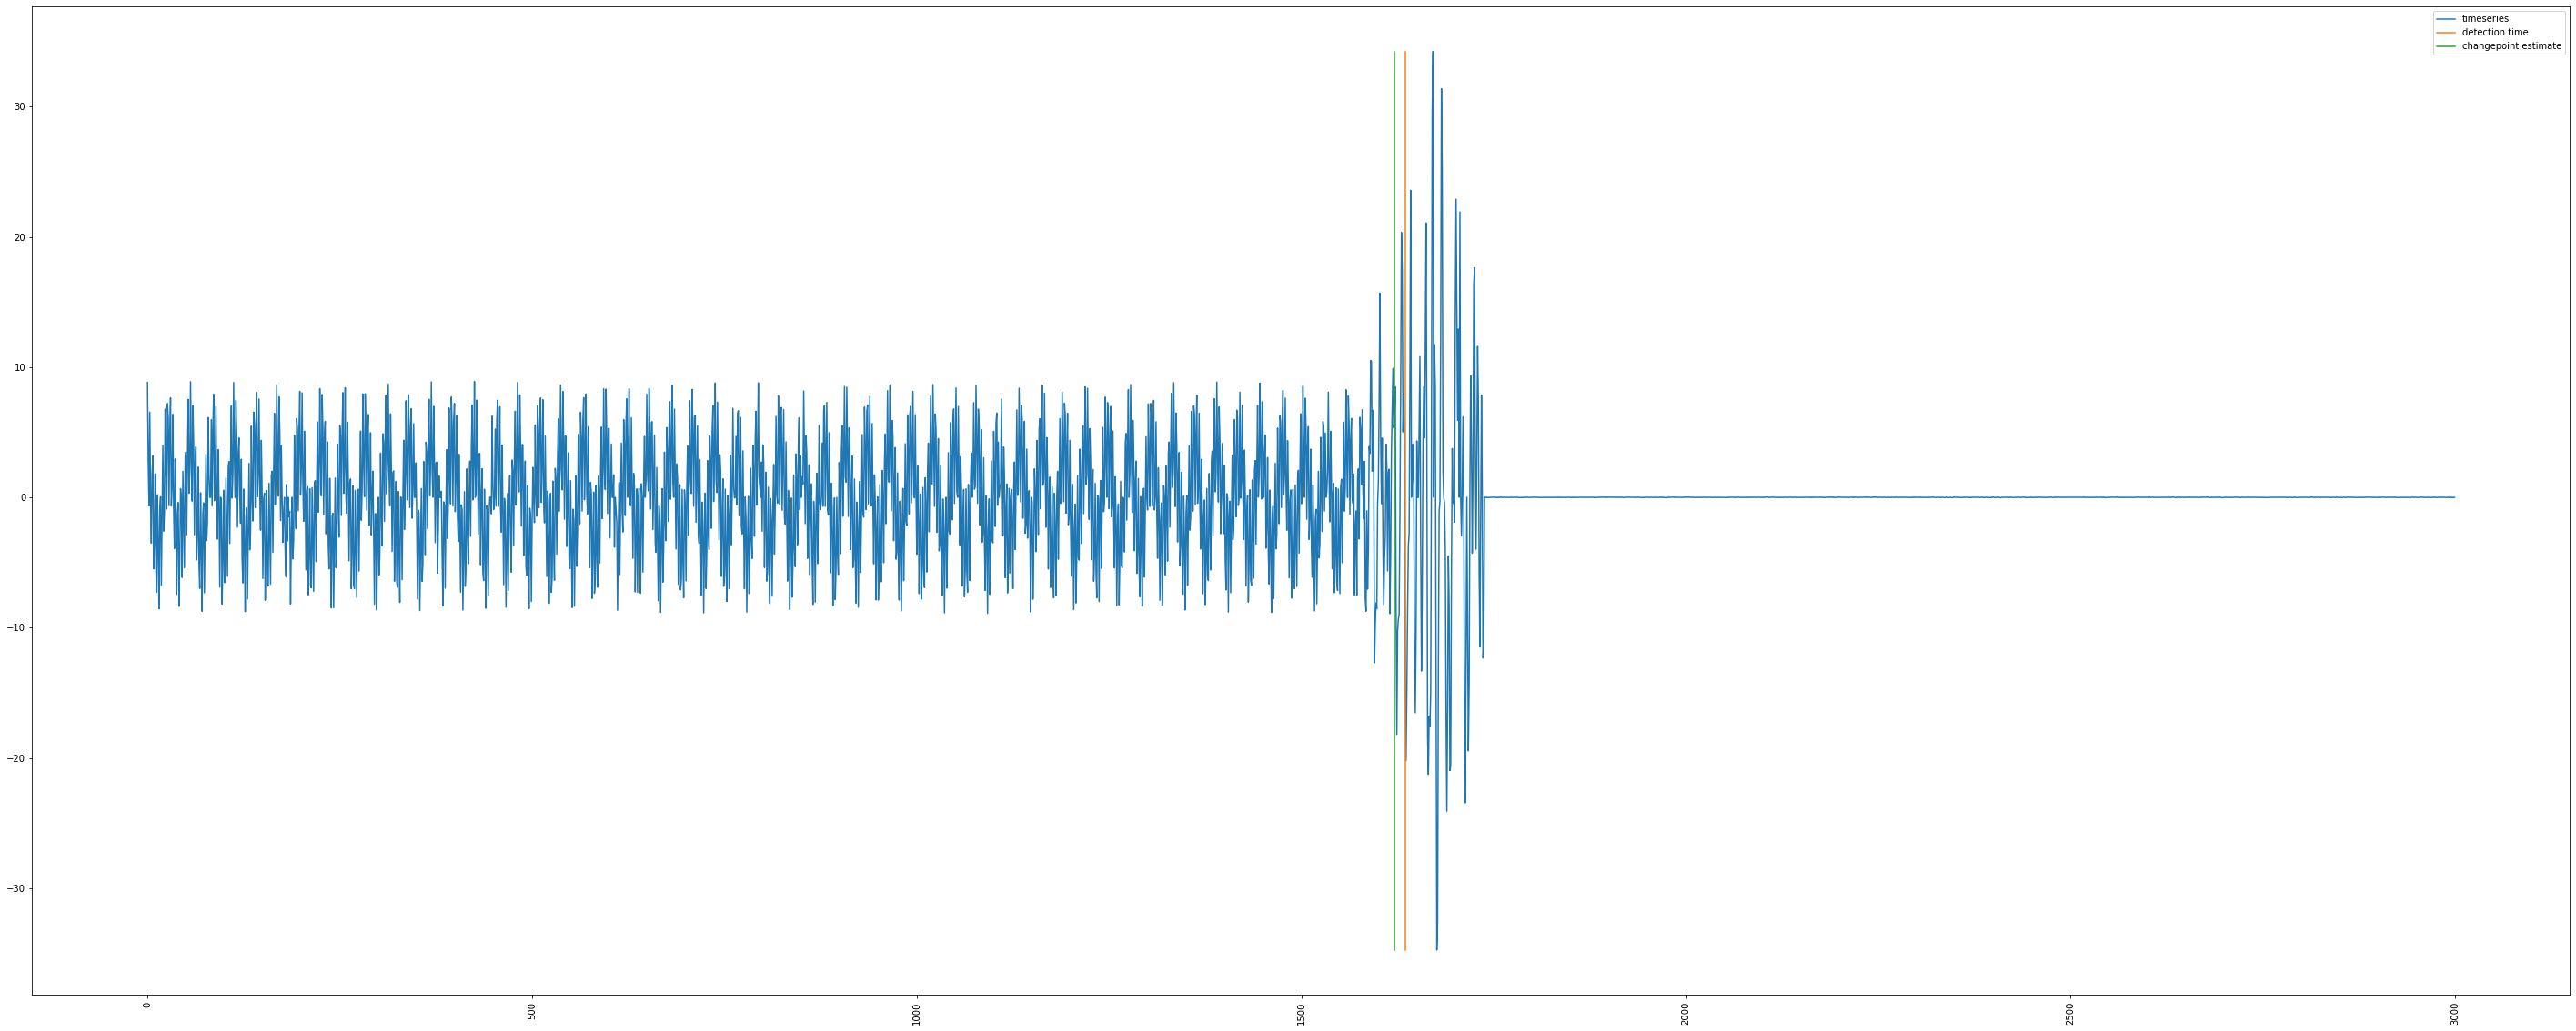

In [14]:
signal2_result = model.offlineDetection(signal_cleaned.iloc[:, 1].values, omit_na=False)

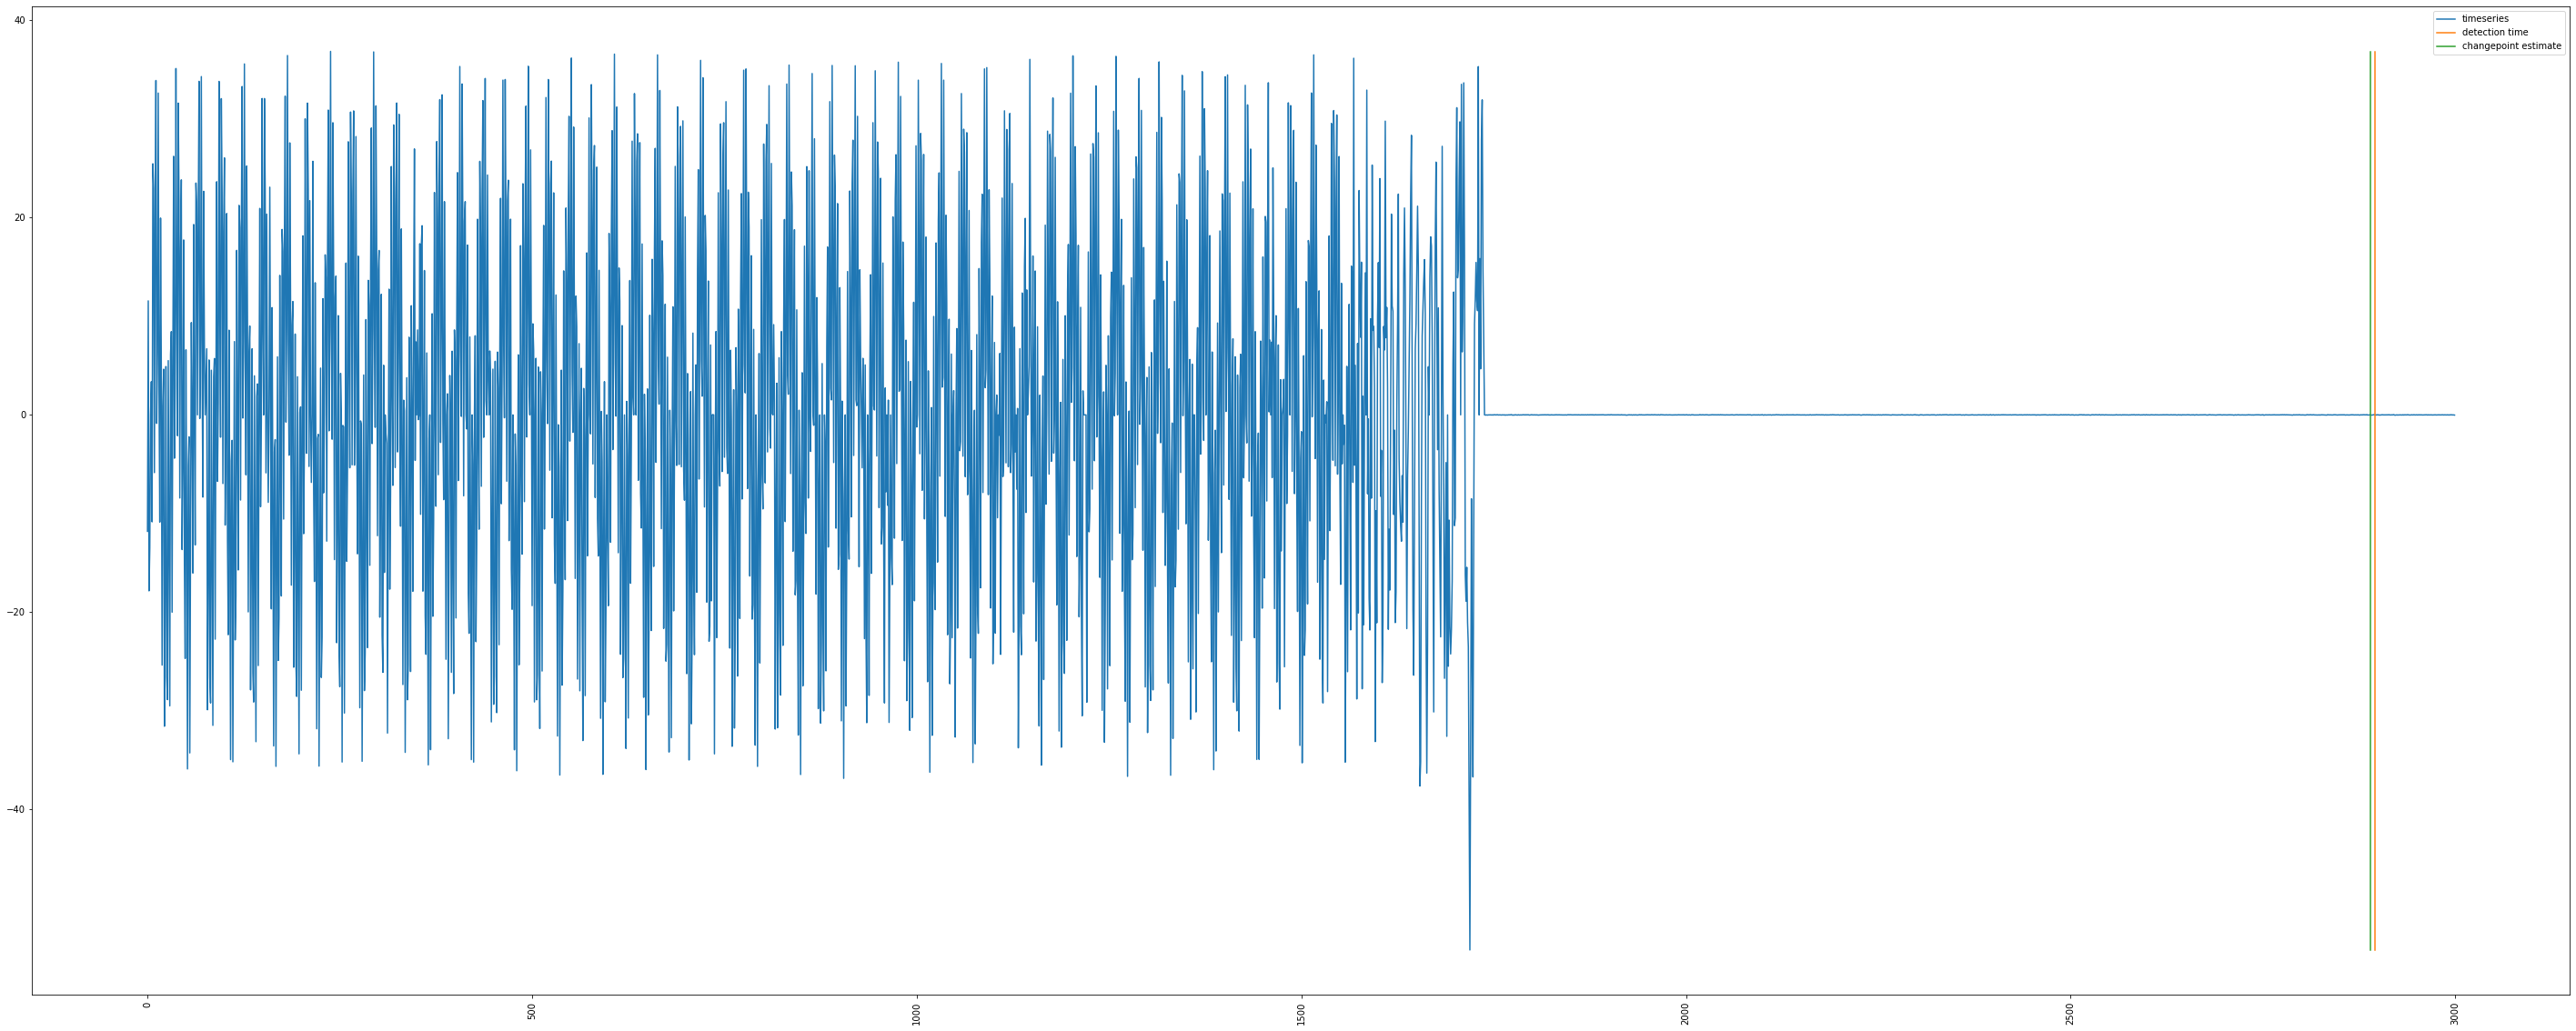

In [15]:
signal3_result = model.offlineDetection(signal_cleaned.iloc[:, 2].values, omit_na=False)

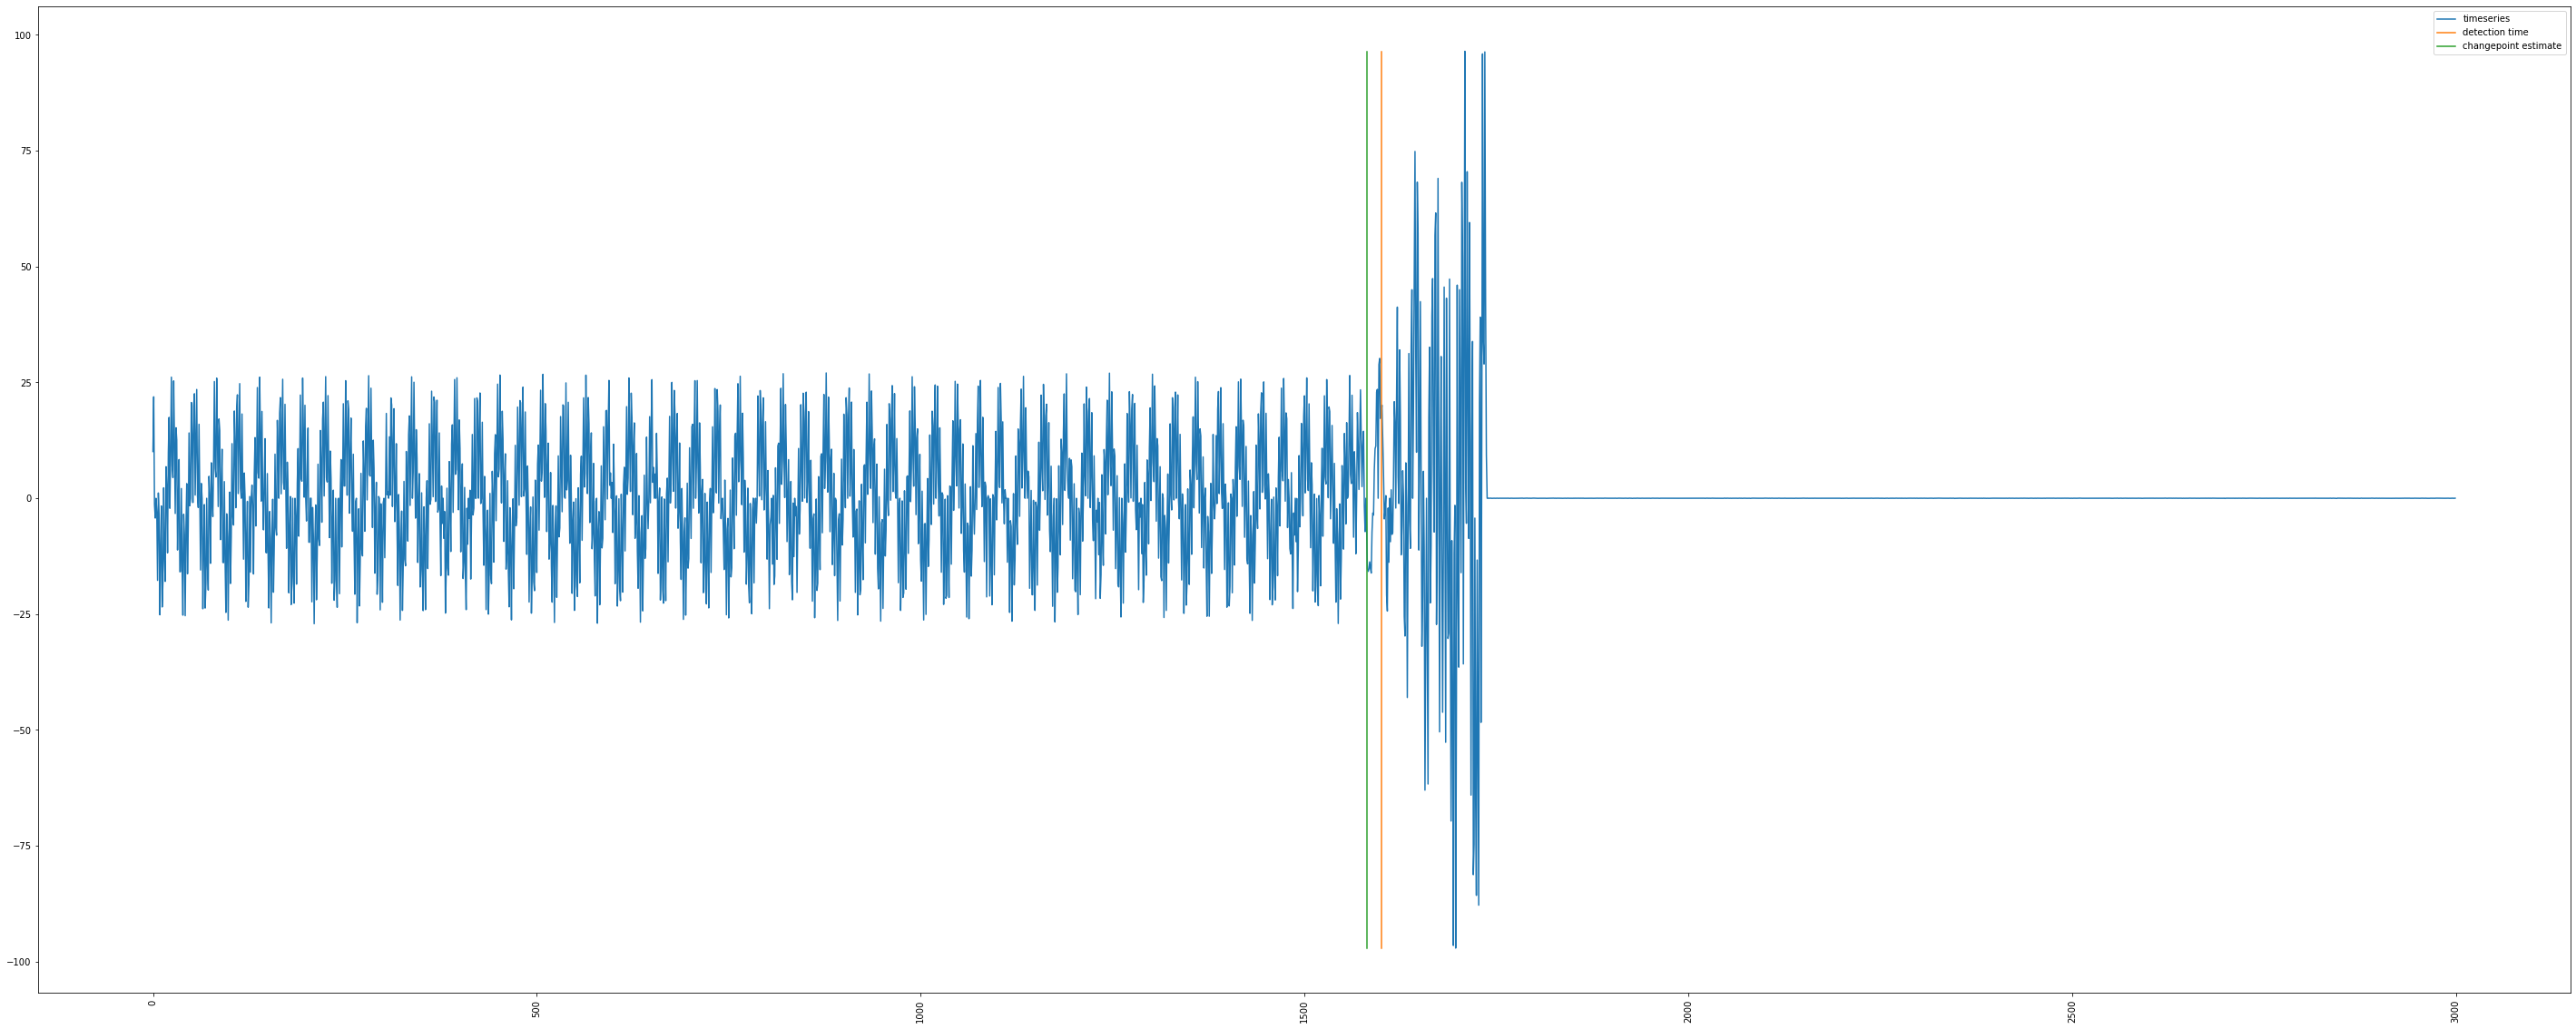

In [16]:
signal4_result = model.offlineDetection(signal_cleaned.iloc[:, 3].values, omit_na=False)

### Saving model

In [17]:
'''
import pickle
filename = './model/changepoint_model.pkl'
outfile = open(filename, 'wb')
pickle.dump(model, outfile)
outfile.close()
'''

"\nimport pickle\nfilename = './model/changepoint_model.pkl'\noutfile = open(filename, 'wb')\npickle.dump(model, outfile)\noutfile.close()\n"

### The Threshold statistic above which we flag a variance shift

In [18]:
model.threshold

3.002125124643232

### The Null threshold Distribution.

Text(3.002125124643232, 150, ' Threshold with 1% designed false positive rate')

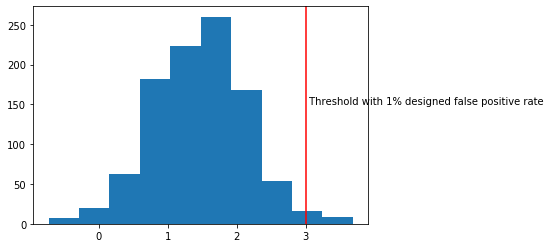

In [19]:
plt.hist(model.null_threshold_distribution)
plt.axvline(x=model.threshold, color="red")
plt.text(model.threshold, 150, r' Threshold with 1% designed false positive rate')

### Here we take the minimum of all the breakpoints and get the timestamp of it 

In [20]:
min_fault_index = min(signal1_result.breakpoints[0], signal2_result.breakpoints[0], signal3_result.breakpoints[0], signal4_result.breakpoints[0])

In [21]:
min_fault_time = data.iloc[min_fault_index, 0]

In [22]:
min_fault_time

'2020-06-11 04:13:02.660886968'

### This is the earliest time where the machine failed.

### Now, we automate this for all the machines . 

Run the below script to automate the process for all machines. The results are stored in a csv. 

In [23]:
#!sh start.sh

### Failed Approach

### Detect frequency shift 
1. The initial idea was to detect frequency shift using stft
2. It looks the normal mode has two fundamental frequencies and when it goes to faulty, there's a multitude of frequencies.
3. Messed up the time axis when i converted to seconds.Had difficulties while getting the original timestamp back.


In [24]:
from scipy import signal

In [25]:
fs = 1/ ((60*60*8)) #Each signal is 8 hrs apart


In [26]:
data = pd.read_csv('./data/exampleco_data/machine_5.csv')
signal_cleaned = data.iloc[:, 1:].reset_index(drop=True).apply(lambda x: med_values_without_outliers(x, 100))

Text(0.5, 0, 'Time [sec]')

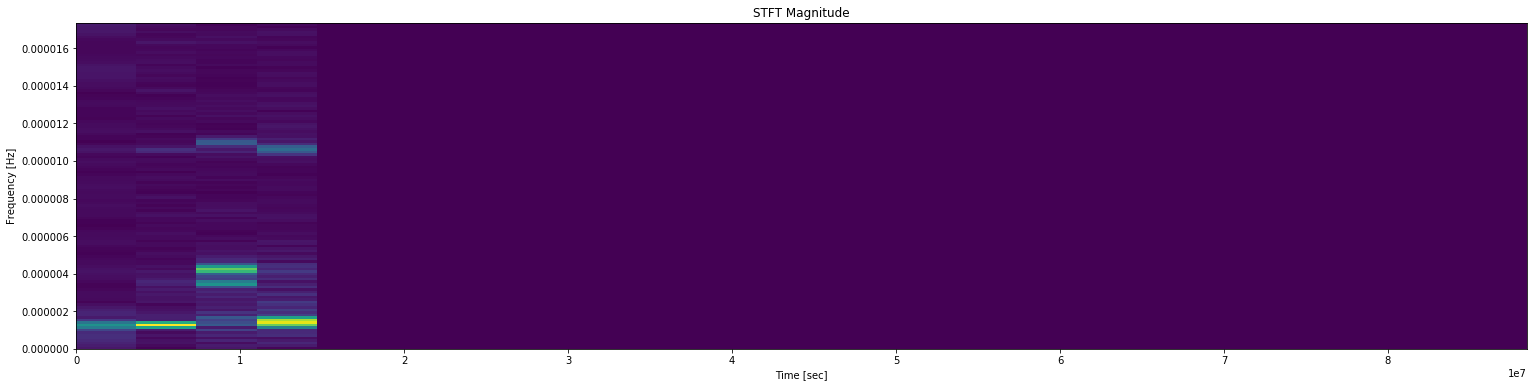

In [27]:
freq, time, mag = signal.stft(signal_cleaned.iloc[:,0], fs)
plt.figure(figsize=(26,6))
plt.pcolormesh(time, freq, np.abs(mag))
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

Text(0.5, 0, 'Time [sec]')

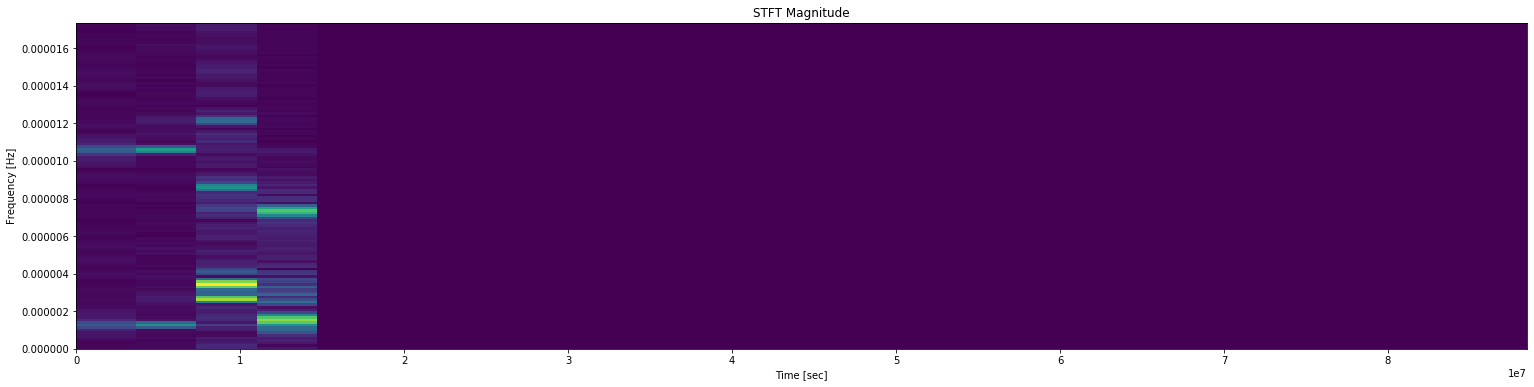

In [28]:
freq, time, mag = signal.stft(signal_cleaned.iloc[:,1], fs)
plt.figure(figsize=(26,6))
plt.pcolormesh(time, freq, np.abs(mag))
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

Text(0.5, 0, 'Time [sec]')

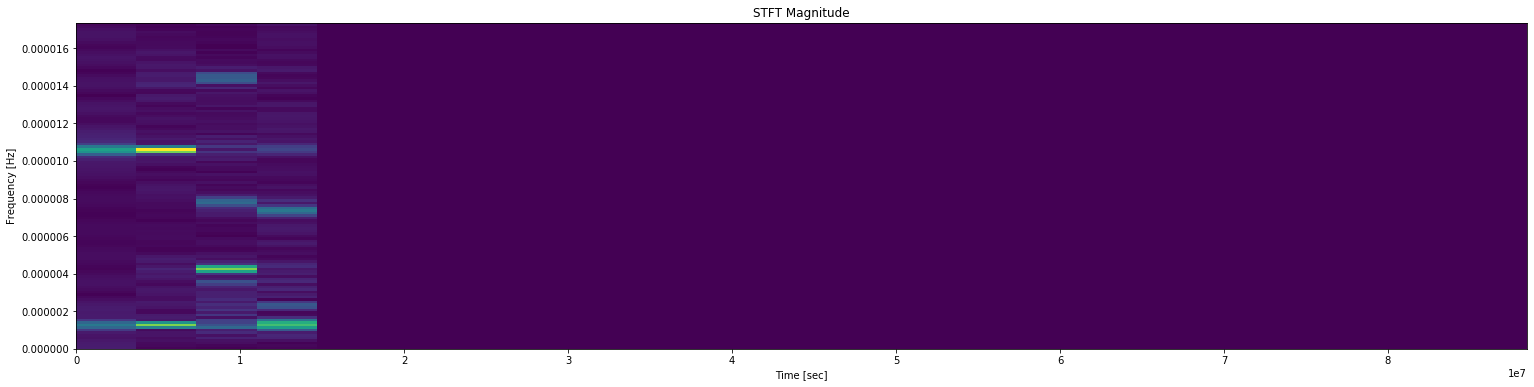

In [29]:
freq, time, mag = signal.stft(signal_cleaned.iloc[:,2], fs)
plt.figure(figsize=(26,6))
plt.pcolormesh(time, freq, np.abs(mag))
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

Text(0.5, 0, 'Time [sec]')

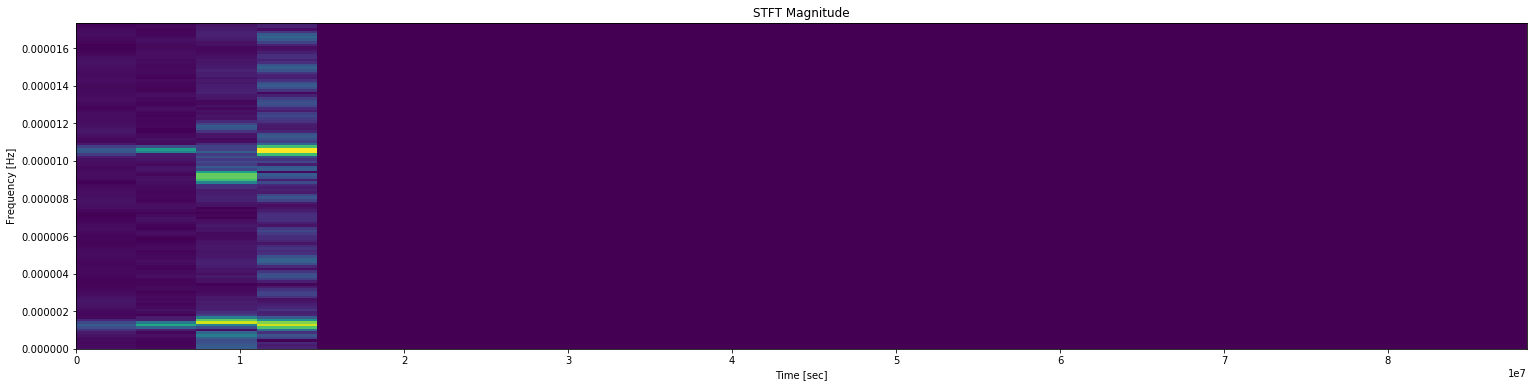

In [30]:
freq, time, mag = signal.stft(signal_cleaned.iloc[:,3], fs)
plt.figure(figsize=(26,6))
plt.pcolormesh(time, freq, np.abs(mag))
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')